In [1]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, InputLayer
from keras.layers.convolutional import Conv2D, MaxPooling2D
import sys
sys.path.append("/root/Gan/jidian/MLexperiments")
sys.path.append("/root/Gan/jidian")
import MLexperiments.classes
from MLexperiments.classes import ReadAutoLabeledData
import tensorflow as tf
import MLexperiments.config.parameters
from keras.layers import LSTM, Reshape
import matplotlib.pyplot as plt
import utils
import keras
from keras.callbacks import ModelCheckpoint
import os
from keras.callbacks import TensorBoard
from time import time
from keras.models import Model
from keras.layers import Input, Dense


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"


FLAGS = None
myDataSet = utils.read_data_sets(one_hot=True, test_size = 0.1, validation_size = 0.1)

(X_train, y_train), (X_test, y_test) , (X_Ftest, y_Ftest)= (myDataSet.train.images, myDataSet.train.labels), (myDataSet.validation.images, myDataSet.validation.labels), (myDataSet.test.images, myDataSet.test.labels)

print(X_train[0].shape)
print(y_train[0])

X_train = X_train.reshape(X_train.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')
X_Ftest = X_Ftest.reshape(X_Ftest.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')

#X_train /= 255
#X_test /= 255

def tran_y(y):
    y_ohe = np.zeros(2)
    if y:
        y_ohe[1] = 1
    else:
        y_ohe[0] = 1
    return y_ohe
# def tran_y(y):
#     return y

y_train_ohe = np.array([tran_y(y_train[i]) for i in range(len(y_train))])
y_test_ohe = np.array([tran_y(y_test[i]) for i in range(len(y_test))])




Using TensorFlow backend.


 np_input shape:  (219559, 100, 10) labelData shape:  (219559,)
read succesful
(1000,)
0


In [2]:
BATCH_SIZE=128
model = Sequential()
#model.add(Input(shape=(MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1)))
# model.add(
#     Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),input_shape=(MLexperiments.config.parameters.SAMPLE_LEN,\
#                                                                        MLexperiments.config.parameters.SAMPLE_HEIGHT, 1)\
#            , padding='valid', activation='relu',name="conv1"))

model.add(
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),batch_input_shape=(None, MLexperiments.config.parameters.SAMPLE_LEN,\
                                                                       MLexperiments.config.parameters.SAMPLE_HEIGHT, 1)\
           , padding='valid', activation='relu',name="conv1"))

#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5,name="dropout1"))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu',name="conv2"))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5,name="dropout2"))
model.add(Conv2D(32, kernel_size=(10, MLexperiments.config.parameters.SAMPLE_HEIGHT - 4),name="conv3", strides=(1, 1), padding='valid', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5,name="dropout3"))

model.add(Reshape((model.get_layer("dropout3").output_shape[1], model.get_layer("dropout3").output_shape[3]), name = "reshape"))

model.add(LSTM(128,  name = "LSTM1"))

model.add(Dense(64, activation='relu', name = "dense1"))
model.add(Dense(32, activation='relu', name = "dense2"))
model.add(Dense(2, activation='softmax', name = "dense3"))


In [ ]:
# BATCH_SIZE=128

# a = Input(shape=(MLexperiments.config.parameters.SAMPLE_LEN,\
#                                                                        MLexperiments.config.parameters.SAMPLE_HEIGHT, 1))
# #model.add(Input(shape=(MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1)))
# # model.add(
# #     Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),input_shape=(MLexperiments.config.parameters.SAMPLE_LEN,\
# #                                                                        MLexperiments.config.parameters.SAMPLE_HEIGHT, 1)\
# #            , padding='valid', activation='relu',name="conv1"))

# # x =    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1)\
# #            , padding='valid', activation='relu',name="conv1")(a)
# x = Flatten()(a)

# x = Dense(2, activation='softmax', name = "dense3")(x)

# model = Model(inputs = [a], outputs = [x])

In [3]:
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
lossHistory = LossHistory()
checkpointer = ModelCheckpoint(filepath='/tmp/best_weights.hdf5', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()),histogram_freq=0, batch_size=BATCH_SIZE, write_graph=True, write_grads=False, \
                          write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

model.summary()
#



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 98, 8, 64)         640       
_________________________________________________________________
dropout1 (Dropout)           (None, 98, 8, 64)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 96, 6, 128)        73856     
_________________________________________________________________
dropout2 (Dropout)           (None, 96, 6, 128)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 87, 1, 32)         245792    
_________________________________________________________________
dropout3 (Dropout)           (None, 87, 1, 32)         0         
_________________________________________________________________
reshape (Reshape)            (None, 87, 32)            0         
__________

In [4]:
history = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=10, batch_size=BATCH_SIZE, \
                callbacks=[\
                           lossHistory,\
                           checkpointer,\
                           tensorboard\
                          ] )

Train on 177843 samples, validate on 19760 samples
Epoch 1/10
177843/177843 [==============================] - 278s - loss: 0.2698 - acc: 0.8982 - val_loss: 0.1212 - val_acc: 0.9516
Epoch 2/10
177843/177843 [==============================] - 269s - loss: 0.1125 - acc: 0.9525 - val_loss: 0.0877 - val_acc: 0.9606
Epoch 3/10
177843/177843 [==============================] - 269s - loss: 0.0726 - acc: 0.9706 - val_loss: 0.0601 - val_acc: 0.9754
Epoch 4/10
177843/177843 [==============================] - 293s - loss: 0.0466 - acc: 0.9831 - val_loss: 0.0324 - val_acc: 0.9890
Epoch 5/10
177843/177843 [==============================] - 293s - loss: 0.0283 - acc: 0.9905 - val_loss: 0.0199 - val_acc: 0.9933
Epoch 6/10
177843/177843 [==============================] - 293s - loss: 0.0199 - acc: 0.9938 - val_loss: 0.0347 - val_acc: 0.9885
Epoch 7/10
177843/177843 [==============================] - 292s - loss: 0.0157 - acc: 0.9952 - val_loss: 0.0126 - val_acc: 0.9966
Epoch 8/10
177843/177843 [======

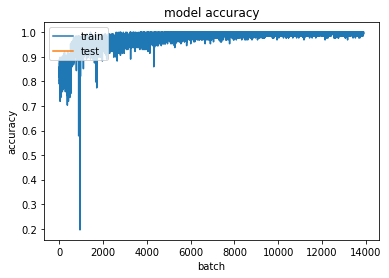

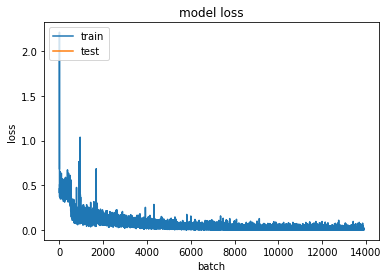

In [5]:

# summarize history for accuracy
plt.plot(lossHistory.acc)
plt.plot(lossHistory.val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(lossHistory.losses)
plt.plot(lossHistory.val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

scores = model.evaluate(X_test, y_test_ohe, verbose=0)

expected: 0
prediction:0


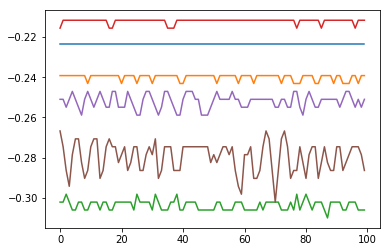

expected: 0
prediction:0


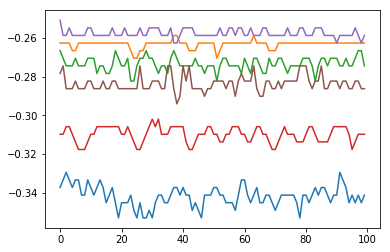

expected: 0
prediction:0


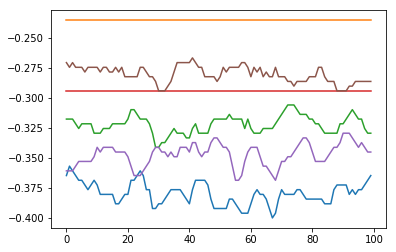

expected: 1
prediction:1


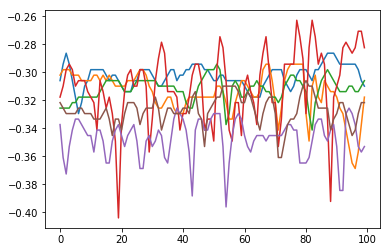

expected: 0
prediction:0


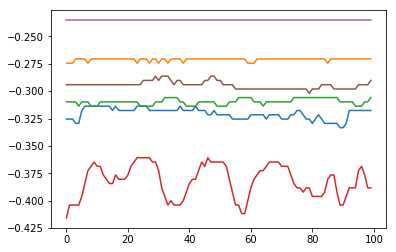

expected: 0
prediction:0


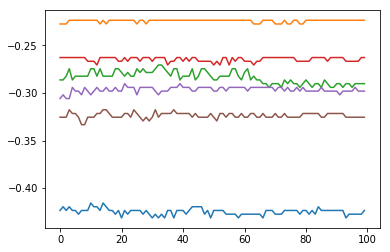

expected: 0
prediction:0


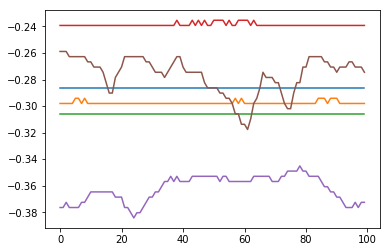

expected: 1
prediction:1


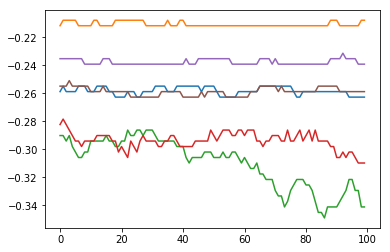

expected: 0
prediction:0


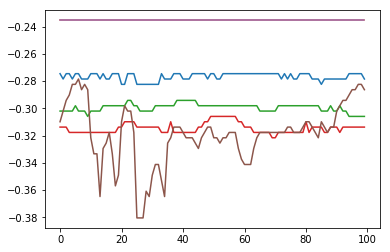

expected: 0
prediction:0


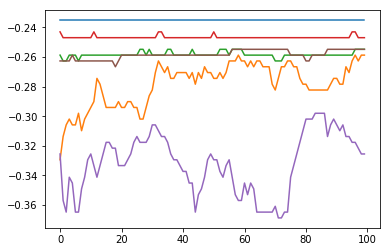

In [8]:

for index in range(10):
    print("expected: "+str( y_Ftest[index]))
    prediction = model.predict(np.expand_dims(X_Ftest[index], axis=0))[0]
    print("prediction:" + str(np.argmax(prediction,axis = 0)))
    time_series = X_test.reshape(X_test.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT) \
        .astype('float32')[index]
    # plt.imshow( X_train.reshape(X_train.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT).astype('float32')[0]);
    # plt.colorbar()
    # plt.show()
    plt.plot(time_series.T[0])
    plt.plot(time_series.T[1])
    plt.plot(time_series.T[2])
    plt.plot(time_series.T[3])
    plt.plot(time_series.T[4])
    plt.plot(time_series.T[5])
    plt.show()
   

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# datagen = ImageDataGenerator(
#        vertical_flip=False,
#         horizontal_flip=True)

# index = 0
# time_series = X_test.reshape(X_test.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT) \
#         .astype('float32')[index]

# # plt.plot(time_series.T[0])
# # plt.show()    
# # plt.plot(time_series.T[1])
# # plt.show()    
# # plt.plot(time_series.T[2])
# # plt.show()    
# # plt.plot(time_series.T[3])
# # plt.show()    
# # plt.plot(time_series.T[4])
# # plt.show()    
# # plt.plot(time_series.T[5])
# # plt.show()    
# # print("+++++++++++++++++++++++++++++++++++++++++++++")    
    
    
# # img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
# # x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# # x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
# x = time_series.reshape((1,)+time_series.shape + (1,))
# print("x.shape  ")
# print(x.shape)
# # the .flow() command below generates batches of randomly transformed images
# # and saves the results to the `preview/` directory
# i = 0
# for batch in datagen.flow(x, batch_size=1):
#     i += 1
#     time_series = batch[0]
#     time_series = time_series.reshape( MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT) \
#         .astype('float32')
#     plt.plot(time_series.T[0])
#     plt.plot(time_series.T[1])
#     plt.plot(time_series.T[2])
#     plt.plot(time_series.T[3])
#     plt.plot(time_series.T[4])
#     plt.plot(time_series.T[5])
#     plt.show()
# #     plt.plot(time_series.T[0])
# #     plt.show()    
# #     plt.plot(time_series.T[1])
# #     plt.show()    
# #     plt.plot(time_series.T[2])
# #     plt.show()    
# #     plt.plot(time_series.T[3])
# #     plt.show()    
# #     plt.plot(time_series.T[4])
# #     plt.show()    
# #     plt.plot(time_series.T[5])
# #     plt.show()    
# #     print("+++++++++++++++++++++++++++++++++++++++++++++")    
    
#     if i > 3:
#         break  # otherwise the generator would loop indefinitely